# **Assignment 6 : Imputation via Regression for Missing Data**

## **Introduction**

Missing data is a common issue in real-world datasets and can negatively affect the performance of machine learning models. This assignment explores different techniques to handle missing values using the UCI Credit Card Default Clients dataset.

Three imputation methods are applied — median imputation, linear regression imputation, and non-linear regression imputation — along with listwise deletion for comparison. The effectiveness of each method is then evaluated using a Logistic Regression classifier to understand how the choice of imputation impacts model performance.

---

### **PART A: Data Preprocessing and Imputation**

**Importing Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report

Mounting to Google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Load and Prepare Data**

In [3]:
df = pd.read_csv("/content/drive/MyDrive/ColabData/UCI_Credit_Card.csv")

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Below we check that there is no null values in any features

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

So, There are total 30,000 entries and none of them have null values .

we set our **target variable** to **'default payment next month'** feature

In [6]:
target = 'default.payment.next.month'

Below code introduces **5% missing values** at random in the columns **'AGE'** and **'BILL_AMT1'** to simulate a real-world **Missing At Random (MAR)** scenario and then displays the count of missing entries in each column.

In [7]:
#creating a duplicate dataframe for next parts
df_copy = df.copy()

# here we are introducing missing values in specific columns of dataframe for dataset 'A':

np.random.seed(42)
for col in ['AGE', 'BILL_AMT1']:
    missing_indices = np.random.choice(df.index, size=int(0.05 * len(df)), replace=False)
    df.loc[missing_indices, col] = np.nan

print("Missing values introduced:")
print(df[['AGE', 'BILL_AMT1']].isnull().sum())

Missing values introduced:
AGE          1500
BILL_AMT1    1500
dtype: int64


for Dataset B and C ,we introduce missing values in 'AGES' below :

In [8]:
np.random.seed(42)
for col in ['AGE']:
    missing_indices = np.random.choice(df.index, size=int(0.05 * len(df)), replace=False)
    df_copy.loc[missing_indices, col] = np.nan

print("Missing values introduced:")
print(df[['AGE']].isnull().sum())

Missing values introduced:
AGE    1500
dtype: int64


## 2. **Imputation Strategy 1: Simple Imputation (Baseline):**

- In this step, a clean copy of the dataset (Dataset A) is created, and all missing values are replaced with the Median of their respective columns.

In [9]:
df_median = df.copy()
for col in ['AGE', 'BILL_AMT1']:
    median_value = df_median[col].median()
    df_median[col].fillna(median_value, inplace=True)

print("\nDataset A (Median Imputation) - Missing values:")
print(df_median[['AGE', 'BILL_AMT1']].isnull().sum())


Dataset A (Median Imputation) - Missing values:
AGE          0
BILL_AMT1    0
dtype: int64


### **Why is Median  preferred over the mean ?**

- The median is less affected by extreme values or outliers in columns like AGE and BILL_AMT1.

- It gives a more accurate central value for skewed financial data over mean .
- furthermore , it Helps maintain the original distribution of the dataset after imputation.

---

## **3.  Imputation Strategy 2: Regression Imputation (Linear):**

**I used following steps to create a Dataframe using linear regression :-**

- Created a copy of the dataset with missing values
- impute_col is the column with missing values ('AGE').

- **Split data into training and test sets**
  - Training set: rows where 'AGE' is not missing.
  -  Test set: rows where 'AGE' is missing.

- Fill missing values in features with the median of the training set.
- **Using GridSearchCV and do hyperparameter Tuning to Train a Linear Regression** model & Fill predicted values in the dataframe
- Finally verifying missing values in the new dataframe df_linear

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import numpy as np

# 1. Create a Copy of Original Dataset
df_linear = df_copy.copy()

impute_col = 'AGE'


# 2. We split the data for Linear Regression
train_data = df_linear[df_linear[impute_col].notnull()]
test_data = df_linear[df_linear[impute_col].isnull()]

X_train = train_data.drop(columns=[impute_col, target])
y_train = train_data[impute_col]
X_test = test_data.drop(columns=[impute_col, target])


# 3. Handle NaN in predictors (temporary median fill)
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_test = X_test.fillna(X_train.median(numeric_only=True))


# 4. Select only numerical columns
X_train_num = X_train.select_dtypes(include=[np.number])
X_test_num = X_test.select_dtypes(include=[np.number])


# 5. Define parameter grid for Ridge Regression (regularized linear model)
param_grid = {
    'alpha':[0.1, 0.01,0.001 ,1 ,10 ,100 ]                                      # Tried alpha = 0.001 to 1000
}


# 6. Initialize Ridge model
ridge_reg = Ridge()


# 7. GridSearchCV to find the best alpha
grid_search = GridSearchCV(
    estimator=ridge_reg,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',                                      # use RMSE as metric
    cv=5,
    n_jobs=-1,
    verbose=1
)


# 8. Fit GridSearch on training data
grid_search.fit(X_train_num, y_train)


# 9. Best model and parameters
best_alpha = grid_search.best_params_['alpha']
best_rmse = -grid_search.best_score_
print(f"Optimal alpha: {best_alpha}")
print(f"Corresponding RMSE (CV mean): {best_rmse:.4f}")


# 10. Retrain Ridge using the best alpha
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(X_train_num, y_train)


# 11. Predict missing values
predicted_values = best_ridge.predict(X_test_num)


# 12. Fill missing AGE values in original dataframe
df_linear.loc[df_linear[impute_col].isnull(), impute_col] = predicted_values


print("\nDataset B (Linear Regression Imputation using Ridge + GridSearchCV) - Missing values:")
print(df_linear[impute_col].isnull().sum())


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Optimal alpha: 10
Corresponding RMSE (CV mean): 8.1754

Dataset B (Linear Regression Imputation using Ridge + GridSearchCV) - Missing values:
0


In [11]:
df_linear.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24.0,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26.0,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34.0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37.0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57.0,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


we now check Dataset B info :

In [12]:
df_linear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  float64
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

Clearly , we replace all NaN values succesfully

## **Assumptions we took :**
---

- **Linear Regression** imputation assumes the missing values in a column (that is , AGE) are **Missing At Random** (MAR) – meaning the chance of a value being missing depends on other observed features, not on the missing value itself.

This allows the model to predict missing entries using relationships with available features.


---

## **4. Imputation Strategy 3: Regression Imputation (Non-Linear)**

## **ASSUMPTIONS:**

**We have to Assume Missing At Random (MAR) and works well for non-linear relationships.**

- I Created a copy of the dataset and identify the column with missing values (that is , AGE).
- Use rows with known values to train a KNN model with nearest neighbours = 19,  find using GridSearchCV and rows with missing values as test.
- Fill missing predictors with the training median.
- Predict missing values using KNN based on nearest neighbors and update the dataset.

----

-> Initially , we tried to find Optimal 'K' using ELbow plot but it was not much fruitful :

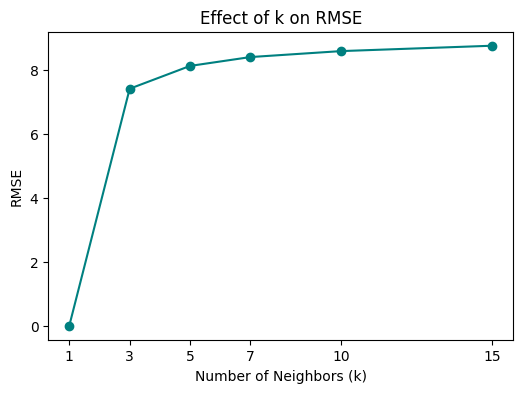

In [13]:
df_nonlinear = df_copy.copy()
impute_col = 'AGE'
known_rows = df_nonlinear[df_nonlinear[impute_col].notnull()]

X_known = known_rows.drop(columns=[impute_col, target])
y_known = known_rows[impute_col]

# Fill missing values in predictors with median
X_known_filled = X_known.fillna(X_known.median(numeric_only=True))



# Test different k values
k_values = [1, 3, 5, 7, 10, 15]
rmse_values = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_known_filled, y_known)
    y_pred = knn.predict(X_known_filled)
    rmse = np.sqrt(mean_squared_error(y_known, y_pred))
    rmse_values.append(rmse)

# Plot RMSE vs k
plt.figure(figsize=(6,4))
plt.plot(k_values, rmse_values, marker='o', linestyle='-', color='teal')
plt.title('Effect of k on RMSE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.xticks(k_values)
plt.show()


The **RMSE V/s Number of Neighbours(k)** plot seems to provide vague information to find **Optimal 'k'** , so it is advisable to find Optimal No. of Neighbours using Methods like GridSearchCV.

---

- We implement the K-Nearest Neighbors (KNN) algorithm in conjunction with GridSearchCV to identify the optimal number of neighbors and create a DataSet from original Dataset having  missing values :-

In [14]:
# 1. Copy dataframe from the copy of original preserved dataframe df_copy
df_nonlinear = df_copy.copy()

# 2. Split into known and unknown AGE
train_data = df_nonlinear[df_nonlinear[impute_col].notnull()]
test_data = df_nonlinear[df_nonlinear[impute_col].isnull()]

X_train = train_data.drop(columns=[impute_col, target])
y_train = train_data[impute_col]
X_test = test_data.drop(columns=[impute_col, target])


# 3. Handle NaN in predictors (temporary median fill)
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_test = X_test.fillna(X_train.median(numeric_only=True))


# 4. Select only numerical columns for regression
X_train_num = X_train.select_dtypes(include=[np.number])
X_test_num = X_test.select_dtypes(include=[np.number])


# 5. Define parameter grid for 'k' (number of neighbors)  &   Initialize KNN regressor
param_grid = {'n_neighbors': list(range(1, 16))}
knn = KNeighborsRegressor()


# 6. GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_num, y_train)


# 7. Get the Best model
best_k = grid_search.best_params_['n_neighbors']
best_rmse = -grid_search.best_score_
print(f" Optimal k: {best_k}")
print(f"Corresponding RMSE (CV mean): {best_rmse:.4f}")


# 8. Trained final model using optimal k which is '15' in our case  &  Predict missing AGE values in test dataset
knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best.fit(X_train_num, y_train)

predicted_values_knn = knn_best.predict(X_test_num)
df_nonlinear.loc[df_nonlinear[impute_col].isnull(), impute_col] = predicted_values_knn


print("\nDataset C (Non-Linear Regression Imputation) - Missing values :")
print(df_nonlinear[impute_col].isnull().sum())


 Optimal k: 15
Corresponding RMSE (CV mean): 9.3301

Dataset C (Non-Linear Regression Imputation) - Missing values :
0


we check the info of Dataset C :

In [15]:
df_nonlinear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  float64
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

Clearly, we can see that all NaN values are successfully replaced with the help of k_Nearest_neighbours

# **PART B: MODEL TRAINING & PERFORMANCE**

**Dataset D** is created by removing all rows containing missing values .

In [16]:
# Dataset D: Listwise Deletion of all rows containg missing values
df_listwise = df.dropna()
print("\nDataset D (Listwise Deletion) shape:", df_listwise.shape)


Dataset D (Listwise Deletion) shape: (27077, 25)


We Now build a 'evaluate_model' function to train All 4 Logistic Regression Model
- We **split all 4 Datasets** into train and testing sets .
- We ensures **Input Features ('X')** are Standarized before Logistic Regression Model(look in the function) for each dataset.
- **Using GridSearchCV, perform hyperparameter tuning** to train a **Logistic Regression model on each four separate datasets**, then generate a classification report for each to observe performance

In [17]:

def evaluate_model(df_input, name):
    df_eval = df_input.copy()


    # Fill any remaining missing values with column medians (safety step)
    df_eval = df_eval.fillna(df_eval.median(numeric_only=True))

    X = df_eval.drop(columns=[target])
    y = df_eval[target]


 # -> Split the datasets into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


 # ->  Standardize the features before training
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    # Base model
    log_reg = LogisticRegression(max_iter=1000)


    # Parameter grid for GridSearchCV
    param_grid = {
        'C': [0.1 ,0.01 ,0.001 ,1 ,10 ,100 ],                                   # Regularization strength
        'penalty': ['l1', 'l2'],                                                # Regularization type
        'solver': ['liblinear', 'saga'],                                        # Solvers that support L1 & L2
        'class_weight':['balanced', None]                                       # preference given to distribution
        }


    # Initialize GridSearchCV ( fixed estimator argument)
    grid_search = GridSearchCV(
        estimator=log_reg,
        param_grid=param_grid,
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )



    # Fit on training data
    grid_search.fit(X_train_scaled, y_train)


    # Get the Best Best model
    best_model = grid_search.best_estimator_
    print(f"\n Best Parameters for {name}: {grid_search.best_params_}")
    print(f" Best CV F1-score: {grid_search.best_score_:.4f}")


    # Evaluate on test data
    y_pred = best_model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"\n{name} - Classification Report:")
    print(classification_report(y_test, y_pred))

    return report


In [18]:
# Evaluate all models
report_A = evaluate_model(df_median, "Model A - Median Imputation")
report_B = evaluate_model(df_linear, "Model B - Linear Regression Imputation")
report_C = evaluate_model(df_nonlinear, "Model C - Non-Linear(KNN) Regression Imputation")
report_D = evaluate_model(df_listwise, "Model D - Listwise Deletion")

Fitting 5 folds for each of 48 candidates, totalling 240 fits

 Best Parameters for Model A - Median Imputation: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
 Best CV F1-score: 0.7812

Model A - Median Imputation - Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4687
           1       0.50      0.52      0.51      1313

    accuracy                           0.78      6000
   macro avg       0.68      0.69      0.68      6000
weighted avg       0.78      0.78      0.78      6000

Fitting 5 folds for each of 48 candidates, totalling 240 fits

 Best Parameters for Model B - Linear Regression Imputation: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
 Best CV F1-score: 0.7812

Model B - Linear Regression Imputation - Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4687
    

**From Classification Reports , following points should be observed :**

- All imputation methods (Median, Linear Regression, KNN) give similar overall performance with **accuracy ~0.78** and comparable precision, recall, and F1-scores.
- **Class '0'** is predicted very well across all models (high precision and recall), while **class '1'** remains harder to predict (low recall and F1-score).
- Listwise deletion reduces the dataset size (27077 vs 30000) but does not significantly improve or worsen performance.
- Overall, imputation method choice has minimal impact on classifier performance in this dataset.

---

# **PART C: COMPARATIVE ANALYSIS**

- Create summary table with Accuracy, Precision, Recall, and Weighted F1-Score

In [19]:
summary = pd.DataFrame({
    'Model': ['A - Median', 'B - Linear', 'C - Non-Linear', 'D - Listwise'],
    'Accuracy': [
        round(report_A['accuracy'], 4),
        round(report_B['accuracy'], 4),
        round(report_C['accuracy'], 4),
        round(report_D['accuracy'], 4)
    ],
    'Precision (Weighted)': [
        round(report_A['weighted avg']['precision'], 4),
        round(report_B['weighted avg']['precision'], 4),
        round(report_C['weighted avg']['precision'], 4),
        round(report_D['weighted avg']['precision'], 4)
    ],
    'Recall (Weighted)': [
        round(report_A['weighted avg']['recall'], 4),
        round(report_B['weighted avg']['recall'], 4),
        round(report_C['weighted avg']['recall'], 4),
        round(report_D['weighted avg']['recall'], 4)
    ],
    'F1-Score (Weighted)': [
        round(report_A['weighted avg']['f1-score'], 4),
        round(report_B['weighted avg']['f1-score'], 4),
        round(report_C['weighted avg']['f1-score'], 4),
        round(report_D['weighted avg']['f1-score'], 4)
    ]
})

print("\nPerformance Summary:")
print(summary)



Performance Summary:
            Model  Accuracy  Precision (Weighted)  Recall (Weighted)  \
0      A - Median    0.7792                0.7832             0.7792   
1      B - Linear    0.7792                0.7832             0.7792   
2  C - Non-Linear    0.7792                0.7832             0.7792   
3    D - Listwise    0.7805                0.7811             0.7805   

   F1-Score (Weighted)  
0               0.7811  
1               0.7811  
2               0.7811  
3               0.7808  


F1-score using Dataset D for logistic model is slightly better than all other Datasets' models .

# **Visualization :**

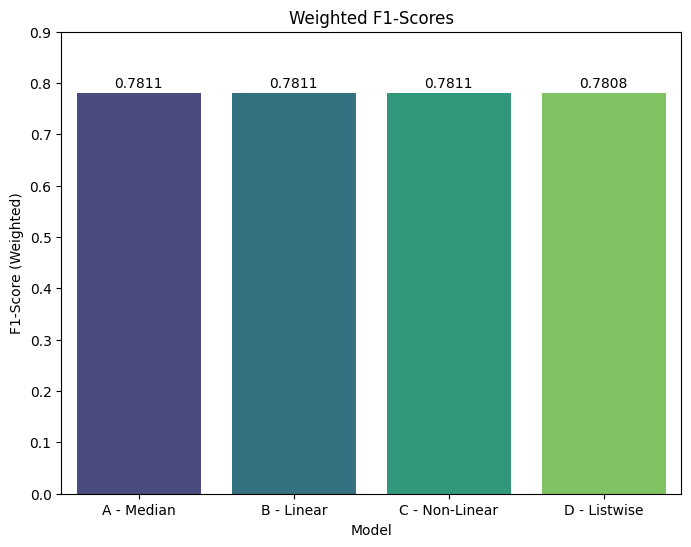

In [20]:
plt.figure(figsize=(8,6))
sns.barplot(data=summary, x='Model', y='F1-Score (Weighted)', palette='viridis')

# Annotate bars with F1 values
for index, row in summary.iterrows():
    plt.text(index, row['F1-Score (Weighted)'] + 0.005, f"{row['F1-Score (Weighted)']:.4f}",ha='center', va='bottom', fontsize=10)

plt.title('Weighted F1-Scores')
plt.ylim(0, 0.9)
plt.show()

We are using Weighted Average F1 score over macro average because the weighted average gives more importance to classes with more samples, making it more representative of overall performance on imbalanced datasets.

---


### **-> trade-off between Listwise Deletion (Model D) and Imputation Models (A, B, C)**
- All models show similar accuracy ( ~ 0.78) and weighted F1 (~0.78).
- Model D uses fewer samples (27077 vs 30000) → less training data → potential bias and weaker generalization.
- Imputation models retain full data, preserving relationships and statistical consistency.

Hence, even with similar performance, imputation is more reliable and scalable for larger missingness.

---

**Why might Model D perform poorly even if the imputed models perform worse?**
- As we discussed above Model D may perform poorly because listwise deletion removes all rows with missing values, reducing the dataset size and losing valuable information.

This loss of data and potential bias weakens the model’s ability to generalize, even if imputed models add small estimation errors.

---


### **-> Which regression method (Linear vs. Non-Linear) performed better and why?**

- Model B (Linear) and Model C (Non-Linear KNN) yield almost identical scores.
- This suggests the relationship between AGE and predictors is largely linear in this dataset.
- Non-linear methods (KNN) can capture complex patterns, but **here they offer no added advantage** since data show simple trends.

Therefore, **Linear Regression Imputation (Model B)** is the better and more efficient choice here — simpler, faster, and equally accurate.

---

## **-> Recommendation on the best strategy for handling missing data ?**

- All imputation models (A–C) outperform listwise deletion conceptually, even if metrics are close.
- Median imputation (A) is the simplest baseline.

- Linear regression imputation (B) offers the best balance of accuracy, simplicity, and interpretability.
- Non-linear imputation (C) is useful only when strong non-linear dependencies exist.
- Based on the results, all imputation methods achieved similar accuracy ( ~ 0.78) and F1-scores (~0.78), while retaining more data than listwise deletion.



**Final Recommendation:** **Linear Regression Imputation (Model B)** is preferred for this dataset . it preserves data quantity, captures relationships accurately, and performs as well as the more complex KNN approach.

---